In [5]:
sra_metadata_filename = "/home/ec2-user/erc-unitigs-poc/Athena_Sept_19_public.acc_mbases.txt"

acc_size = dict()
with open(sra_metadata_filename) as f:
    f.readline()
    for line in f:
        acc, size = line.split()
        size = int(size)
        acc_size[acc] = size
    
print(len(acc_size))

26475979


In [6]:

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np


sizes = np.array(list(acc_size.values()))
# Calculate the histogram using numpy
#hist, bins = np.histogram(sizes, bins=20)  # Adjust bins as necessary

#sizes_max_adjusted = (sizes.max() // 100000 + 1) * 100000
#bin_edges = np.arange(0, sizes_max_adjusted, 100000)

bin_edges = [0,10000,20000,50000,100000,500000,1000000]

# Calculate the histogram using numpy and the defined bin edges
hist, bins = np.histogram(sizes, bins=bin_edges)




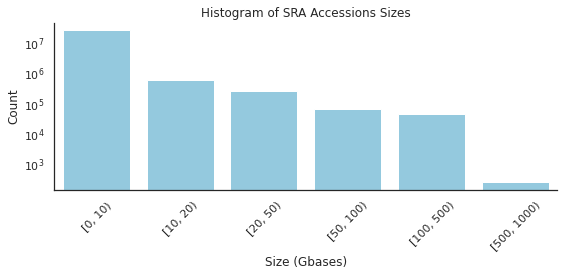

In [7]:
hist_df = pd.DataFrame({
    'Bin_Start': bins[:-1],
    'Frequency': hist
})
    
# Plot the histogram using Seaborn
sns.set_theme(style="white")

# Calculate mid points of the bins for setting x-ticks
mid_points = (bins[:-1] + bins[1:]) / 2

# Create interval labels for x-ticks
interval_labels = [f"[{int(bins[i])//1000}, {int(bins[i+1])//1000})" for i in range(len(bins)-1)]

# Plotting
plt.figure(figsize=(8, 4))
sns.barplot(x=mid_points, y=hist, color='skyblue', ci=None, log=True)

# Setting x-ticks with interval labels
plt.xticks(ticks=np.arange(len(mid_points)), labels=interval_labels, rotation=45)


plt.title("Histogram of SRA Accessions Sizes")
plt.xlabel("Size (Gbases)")
plt.ylabel("Count")


# Adjust x-ticks for better readability
plt.xticks(rotation=45)
plt.tight_layout()

# Remove the top and right spines for aesthetics
sns.despine()

plt.savefig("sra_size_histogram.png",dpi=300)

# Show the plot
plt.show()


In [14]:
[(x,y) for (x,y) in acc_size.items() if y > 2000000]

[]

In [3]:
import boto3
from boto3.dynamodb.conditions import Key, Attr
# Initialize the SimpleDB client
client = boto3.client('sdb')

region='us-east-1'
domain_name = "serratus-batch-unitigs"

query_expression = 'select * from `{}` where `cuttlefish_x64_time` is not null  limit 2000'.format(domain_name)
next_token = None
records = []

while True:
    request_params = {
        'SelectExpression': query_expression,
        'ConsistentRead': True
    }

    # Only add NextToken to the parameters if it's not None
    if next_token:
        request_params['NextToken'] = next_token

    response = client.select(**request_params)

    # Process the response. In this case, just appending to a list, but you might want to process in batches.
    records.extend(response['Items'])

    # If 'NextToken' is in the response, that means there's more data. Otherwise, break.
    next_token = response.get('NextToken')
    if not next_token:
        break

# Print the items from the response
parsed_items = {}
res = []
for item in records:
    item_name = item['Name']
    attributes = {attribute['Name']: attribute['Value'] for attribute in item['Attributes']}
    parsed_items[item_name] = attributes
    cuttlefish_time, cuttlefish_mem = None,None
    if 'cuttlefish_x64_time' in parsed_items[item_name]:
        cuttlefish_time = float(parsed_items[item_name]['cuttlefish_x64_time'])
    if 'cuttlefish_x64_mem' in parsed_items[item_name]:
        cuttlefish_mem = float(parsed_items[item_name]['cuttlefish_x64_mem'])
    if cuttlefish_time is not None:
        if item_name not in acc_size:
            #print("huh?",item_name)
            # basically accessions that are too short reads
            pass
        else:
            res += [(item_name, acc_size[item_name], cuttlefish_time, cuttlefish_mem)]
        

len(res)


NameError: name 'acc_size' is not defined

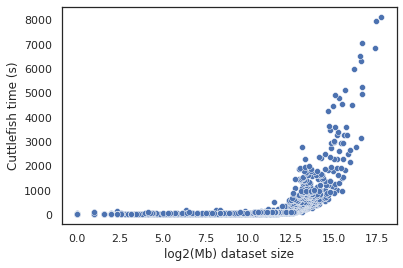

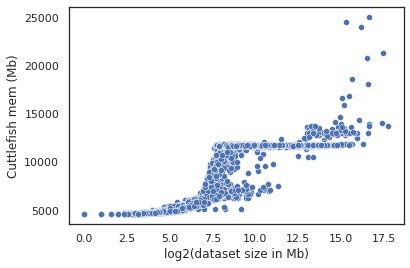

      Accession size (Mb)  Cuttlefish time (s)
0                       2             1.990494
1                       5            10.001507
2                       0            10.005369
3                       0            10.008945
4                       2            10.009139
...                   ...                  ...
6173                14569           989.020207
6174                   93            99.048086
6175                 2180            99.538032
6176                 1632            99.780469
6177                 1534            99.853642

[6178 rows x 2 columns]
      Accession size (Mb)  Cuttlefish mem (Mb)
0                       2          4586.812500
1                       5          4606.531250
2                       0          4562.625000
3                       0          4563.656250
4                       2          4589.765625
...                   ...                  ...
6173                14569         11767.687500
6174                   93          

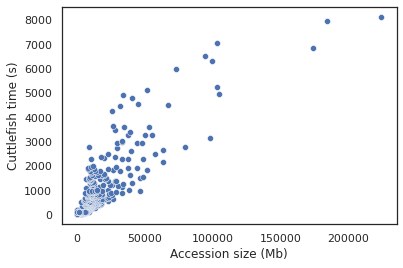

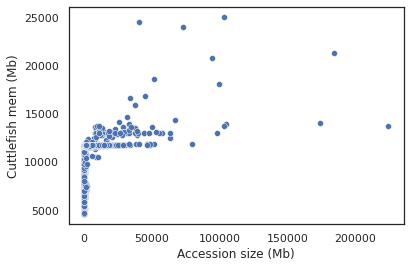

In [15]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from math import log

# Remove the top and right spines for aesthetics
sns.despine()

df = pd.DataFrame([(log(x[1]+1)/log(2),x[2]) for x in res], columns=["log2(Mb) dataset size","Cuttlefish time (s)"])
df2 = pd.DataFrame([(log(x[1]+1)/log(2),x[3]) for x in res], columns=["log2(dataset size in Mb)","Cuttlefish mem (Mb)"])
#print(df)
#print(df2)
# Create the scatter plot
sns.scatterplot(x="log2(Mb) dataset size", y="Cuttlefish time (s)", data=df)
plt.show()
sns.scatterplot(x="log2(dataset size in Mb)", y="Cuttlefish mem (Mb)", data=df2)
plt.show()

df = pd.DataFrame([(x[1],x[2]) for x in res], columns=["Accession size (Mb)","Cuttlefish time (s)"])
df2 = pd.DataFrame([(x[1],x[3]) for x in res], columns=["Accession size (Mb)","Cuttlefish mem (Mb)"])
print(df)
print(df2)
# Create the scatter plot
sns.scatterplot(x="Accession size (Mb)", y="Cuttlefish time (s)", data=df)
plt.show()
sns.scatterplot(x="Accession size (Mb)", y="Cuttlefish mem (Mb)", data=df2)
plt.show()

    
# Display the plot
plt.show()

In [2]:
#acc_size['SRR20706826']
parsed_items['SRR14407446']

KeyError: 'SRR14407446'